In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
from hiv_patient import HIVPatient
from buffer import Buffer

### Create dataset

In [3]:
patient = HIVPatient(clipping=False,logscale=False)

In [4]:
FQI_buffer = Buffer(50000)


In [5]:
for j in tqdm(range(30)):
    s = patient.reset(mode="unhealthy")
    for i in range(200):
        a = np.random.choice(4)
        s_, r, d, _ = patient.step(a)
        FQI_buffer.append(s,a,r,s_,d)
        s = s_



100%|██████████| 30/30 [08:28<00:00, 16.96s/it]


### FQI 

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
from typing import Optional,List, Callable
from sklearn.base import BaseEstimator

def estimator_factory(*args, **kwargs):
    return RandomForestRegressor(*args, **kwargs)


def update(memory : Buffer,
    gamma : float = 0.98,
    estimator : Optional[BaseEstimator] = None,
    estimator_factory: Callable = estimator_factory):

    states, actions, rewards, next_state, done  = memory.get()
    actions = np.expand_dims(actions,axis=1)
    target = np.expand_dims(rewards,axis=1)
    #target = rewards

    if estimator is not None:
        q_values = np.zeros((len(rewards),4))
        for a in range(4):
            actions_ = a*np.ones((len(rewards),1))
            X = np.concatenate((next_state,actions_),axis=1)
            q_values[:,a] = estimator.predict(X)
            
        #print(f"q_values --> {q_values}")
        qmax = np.expand_dims(np.max(q_values,axis=1),axis=1)
        #print(f"Shape de qmax --> {qmax.shape}, Shape de target --> {target.shape}, Shape de done --> {done.shape}")
        target += gamma*qmax * (1 - np.expand_dims(done,axis=1))
        #print(f"Shape de target --> {target.shape}")

    if estimator is None:
        estimator = estimator_factory()


    #print(f"States shape --> {states.shape}, actions shape --> {actions.shape},target{target.shape}")
    data = np.concatenate((states,actions),axis=1)
    #print(f"Data shape --> {data.shape}")
    estimator.fit(data,target)


    return estimator






### Premier entraînement !

In [8]:
estimator = None
for _ in tqdm(range(100)):

    estimator = update(FQI_buffer,estimator=estimator)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1097/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  1%|          | 1/100 [00:03<06:22,  3.86s/it]/tmp/ipykernel_1097/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  2%|▏         | 2/100 [00:08<06:44,  4.12s/it]/tmp/ipykernel_1097/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  3%|▎         | 3/100 [00:13<07:14,  4.48s/it]/tmp/ipykernel_1097/1251894869.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

### Deuxième entraînement

In [9]:
for j in tqdm(range(30)):

    s = patient.reset(mode="unhealthy")

    for step in range(200):
        
        if np.random.random()<0.15:
            action = np.random.choice(4)
        
        else:
            if estimator is not None:
                greedy = np.zeros((4,2))
                for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
                    sta = np.expand_dims(s,axis=1)
                    act = np.expand_dims(np.array([a]),axis=1)
                    X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
                    q = estimator.predict(X)
                    #print(f'Q -->{q}')
                    greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
                action = greedy[np.argmax(greedy[:,0]),0]
            
            else:
                action = np.random.choice(4)


        s_, r, d, _ = patient.step(int(action))
        FQI_buffer.append(s,a,r,s_,d)
        s = s_



100%|██████████| 30/30 [20:02<00:00, 40.08s/it]


In [37]:
while _ in tqdm(range(100)):
    estimator = update(FQI_buffer,estimator=estimator)

100%|██████████| 100/100 [00:00<00:00, 56096.08it/s]


### Affichons les résultats

In [29]:

s = patient.reset(mode="unhealthy")
T1,T2,T1_,T2_,V,E = np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200)
actions = []
for step in tqdm(range(200)):
    T1[step], T2[step], T1_[step], T2_[step], V[step], E[step] = s 

    greedy = np.zeros((4,2))
        
    for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
        sta = np.expand_dims(s,axis=1)
        act = np.expand_dims(np.array([a]),axis=1)
        X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
        q = estimator.predict(X)
                    #print(f'Q -->{q}')
        greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
    action = greedy[np.argmax(greedy[:,0]),0]
    actions += [action]
            


    s_, r, d, _ = patient.step(int(action))
    FQI_buffer.append(s,a,r,s_,d)
    s = s_

100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


Post traitement

In [35]:
actions

[3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0

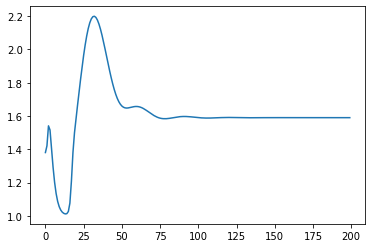

In [32]:
plt.plot(np.log10(E))

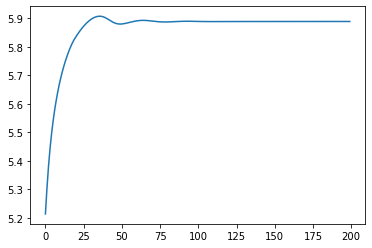

In [33]:
plt.plot(np.log10(T1))

In [15]:
FQI_buffer.get()

(array([[1.63573000e+05, 1.19450000e+04, 5.00000000e+00, 4.60000000e+01,
         6.39190000e+04, 2.40000000e+01],
        [2.00984608e+05, 8.59620520e+02, 5.61261871e+01, 2.70306597e+01,
         3.46017570e+03, 2.63445446e+01],
        [2.39414505e+05, 1.23822123e+02, 1.43947180e+02, 1.56645100e+01,
         7.66274163e+02, 3.52487135e+01],
        ...,
        [7.74589963e+05, 3.21815372e+03, 3.42440797e+01, 4.51712206e+01,
         1.21244139e+04, 3.89012715e+01],
        [7.74590793e+05, 3.21810210e+03, 3.42446478e+01, 4.51712502e+01,
         1.21242212e+04, 3.89016062e+01],
        [7.74591720e+05, 3.21806461e+03, 3.42450714e+01, 4.51712851e+01,
         1.21240810e+04, 3.89019507e+01]]),
 array([3, 2, 3, ..., 3, 3, 3]),
 array([ 6008.1       , 16198.52698345, 23572.08610702, ...,
        26088.83009048, 26089.18411797, 26089.54260198]),
 array([[2.00984608e+05, 8.59620520e+02, 5.61261871e+01, 2.70306597e+01,
         3.46017570e+03, 2.63445446e+01],
        [2.39414505e+05, 1.2

In [16]:
np.array(FQI_buffer.actions).shape

(12200,)

In [80]:
_, _, rewards, _, _  = FQI_buffer.get()